Scores: [28.78787878787879, 29.015151515151516]
Mean Accuracy: 28.902%
Scores: [44.015151515151516, 45.3030303030303]
Mean Accuracy: 44.659%
Scores: [55.45454545454545, 53.03030303030303]
Mean Accuracy: 54.242%
Scores: [58.10606060606061, 63.33333333333333]
Mean Accuracy: 60.720%
Scores: [68.03030303030303, 65.9090909090909]
Mean Accuracy: 66.970%
Scores: [70.3030303030303, 67.04545454545455]
Mean Accuracy: 68.674%
Scores: [73.10606060606061, 73.63636363636363]
Mean Accuracy: 73.371%
Scores: [73.18181818181819, 76.36363636363637]
Mean Accuracy: 74.773%
Scores: [76.2878787878788, 74.92424242424242]
Mean Accuracy: 75.606%
Scores: [75.9090909090909, 73.93939393939394]
Mean Accuracy: 74.924%


Text(0, 0.5, 'Accuracy %')

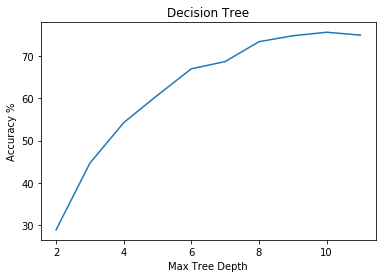

In [3]:
from random import seed
from random import randrange
from csv import reader
import sklearn
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from pandas import ExcelFile
from pandas import ExcelWriter
from sklearn.preprocessing import OneHotEncoder 

df = pd.read_excel('Disposition Data.xlsx', sheet_name='Sheet1')
# Reading dataset into pandas

B = df.select_dtypes(exclude=[object])
A = df.select_dtypes(include=[object])
# Choosing only object datatypes
A.head(3)
A.shape
from sklearn import preprocessing
A.columns
le = preprocessing.LabelEncoder()
# Using label encoder to encode object data
X_2 = A.apply(le.fit_transform)
# Applying label encoder to dataset
X_2.head()

C = pd.concat([B,X_2],axis=1)
C = C.fillna(0)
# Concatenating new labeled data with old labeled data

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(C),columns = C.columns)
#scaling data to means and standard deviations from means
dataset = df_scaled.values.tolist()
#dataset is required to be in list format for decision tree algorithm
 
# Split a dataset into k folds
def Cross_Val(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split

 

# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right
 
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini
 
# Select the best split point for a dataset
def get_split(dataset):
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}
 
# Create a terminal node value
def to_terminal(group):
    term = [row[-1] for row in group]
    return max(set(term), key=term.count)
 
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)
 
# Build a decision tree
def build_tree(train, max_depth, min_size):
    start = get_split(train)
    split(start, max_depth, min_size, 1)
    return start
 
# Make a prediction with a decision tree
def predict(node, row):
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']
 
# Classification Tree Algorithm
def decision_tree(train, test, max_depth, min_size):
    tree = build_tree(train, max_depth, min_size)
    pred = list()
    for row in test:
        prediction = predict(tree, row)
        pred.append(prediction)
    return(pred)

# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0
 
# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = Cross_Val(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# Looping through different variants of max tree depth to find optimal parameters
Max_depth=[]
def depth (e):
    for i in range(10):
# evaluate algorithm
        n_folds = 2
        max_depth = e
        min_size = 10
        scores = evaluate_algorithm(dataset, decision_tree, n_folds, max_depth, min_size)
        print('Scores: %s' % scores)
        print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))
        e+=1
        Max_depth.append(sum(scores)/float(len(scores)))

depth(2)
Max_depth

x = [i for i in range(2,12)]
y = Max_depth

#graphing accuracies of different trees depths to display optimal parameters
plt.plot(x,y)
plt.title (r"Decision Tree")
plt.xlabel(r"Max Tree Depth")
plt.ylabel(r"Accuracy %")

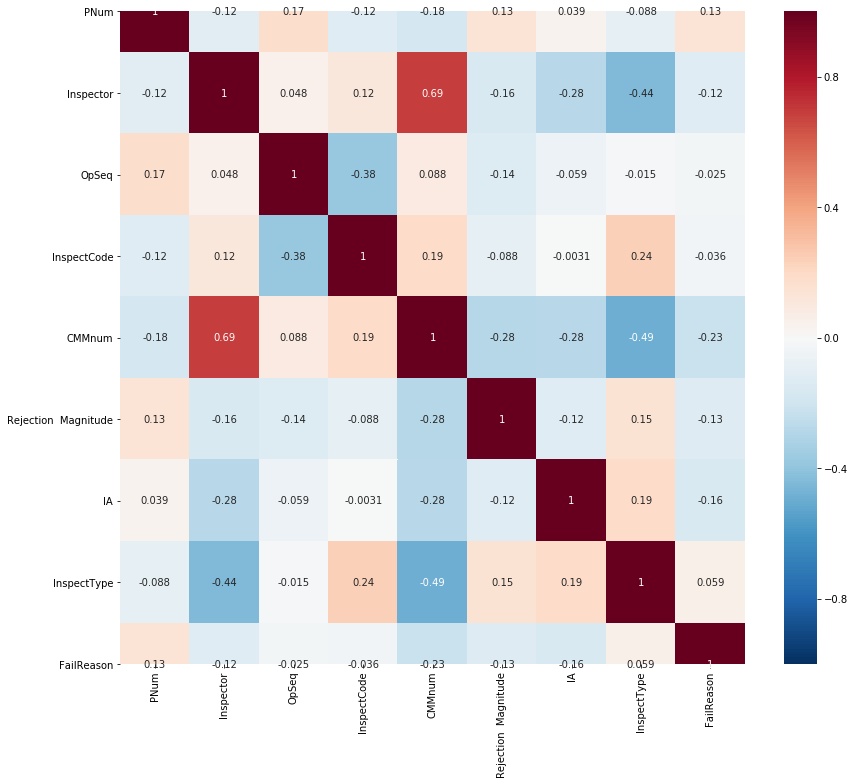

In [4]:
from random import seed
from random import randrange
from csv import reader
import sklearn
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from pandas import ExcelFile
from pandas import ExcelWriter
from sklearn.preprocessing import OneHotEncoder
import seaborn as sns

df = pd.read_excel('Disposition Data.xlsx', sheet_name='Sheet1')
# Reading dataset into pandas

B = df.select_dtypes(exclude=[object])
A = df.select_dtypes(include=[object])
# Choosing only object datatypes
A.head(3)
A.shape
from sklearn import preprocessing
A.columns
le = preprocessing.LabelEncoder()
# Using label encoder to encode object data
X_2 = A.apply(le.fit_transform)
# Applying label encoder to dataset
X_2.head()

C = pd.concat([B,X_2],axis=1)
C = C.fillna(0)
# Concatenating new labeled data with old labeled data


#Creating correlation matrix of encoded data using seaborn heatmap
correlation = C.corr()
plt.figure(figsize=(14, 12))
heatmap = sns.heatmap(correlation, annot=True, linewidths=0, vmin=-1, cmap="RdBu_r")

Text(0, 0.5, 'Accuracy %')

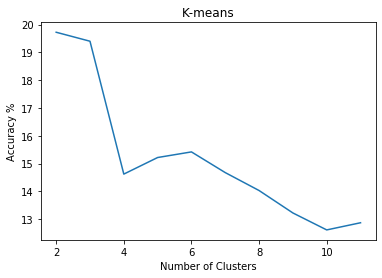

In [29]:
from random import seed
from random import randrange
from csv import reader
import sklearn
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from pandas import ExcelFile
from pandas import ExcelWriter
from sklearn.preprocessing import OneHotEncoder 

df = pd.read_excel('Disposition Data.xlsx', sheet_name='Sheet1')
#reading in data to pandas dataframe
B = df.select_dtypes(exclude=[object])
A = df.select_dtypes(include=[object])
#selecting only object data types 
A.head(3)
A.shape
from sklearn import preprocessing
A.columns
#preprocessing object data with sklearn label encoder
le = preprocessing.LabelEncoder()
X_2 = A.apply(le.fit_transform)
X_2.head()
#combining newly labeled object data with old data
C = pd.concat([B,X_2],axis=1)
C = C.fillna(0)

#scaling data to means and stardard deviations
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
df_scaled = pd.DataFrame(ss.fit_transform(C),columns = C.columns)

#splitting dataset into features and labels
y = df_scaled["IA"]
x = df_scaled.drop('IA', axis=1)

#trying PCA on features
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(x)

# x = principalComponents

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
#splitting data into training set and test set
kmeans = KMeans(n_clusters=4)
kmeans.fit(X_train)

y_pred = kmeans.predict(X_test)
#making predictions on test data based on training data

#using sklearn v_measure_score to measure accuracy
from sklearn import metrics
from sklearn.metrics.cluster import v_measure_score
v_measure_score(y_test, y_pred)

#looping throuhg different number of cluser values to find optimal amount
Number_of_clusters=[]
def list (b):
    for i in range(10):
        kmeans = KMeans(n_clusters=b)
        kmeans.fit(X_train)

        y_pred = kmeans.predict(X_test)
        #making predictions on test data based on training data

        from sklearn import metrics
        from sklearn.metrics.cluster import v_measure_score
        v_measure_score(y_test, y_pred)

        Number_of_clusters.append(v_measure_score(y_test, y_pred)*100)
        b+=1
list(2)
Number_of_clusters


import matplotlib.pyplot as plt
x = [i for i in range(2,12)]
y= Number_of_clusters
#graphing different cluster values and accuracies
plt.plot(x,y)
plt.title (r"K-means")
plt.xlabel(r"Number of Clusters")
plt.ylabel(r"Accuracy %")

Accuracy for Random Forest: 0.8760643330179754
0.8675432315348537
Accuracy for Random Forest: 0.8836329233680227
0.8268644158819949
Accuracy for Random Forest: 0.9035004730368968
0.8353740619808673
Accuracy for Random Forest: 0.8959318826868495
0.8609824209659518
Accuracy for Random Forest: 0.8997161778618732
0.8514689666036547
Accuracy for Random Forest: 0.9016083254493851
0.8561930744114109
Accuracy for Random Forest: 0.8949858088930936
0.8505202067938362
Accuracy for Random Forest: 0.9044465468306528
0.8826956951366214
Accuracy for Random Forest: 0.9176915799432356
0.8514571622927929
Accuracy for Random Forest: 0.9148533585619678
0.8637742023257147


Text(0, 0.5, 'Accuracy %')

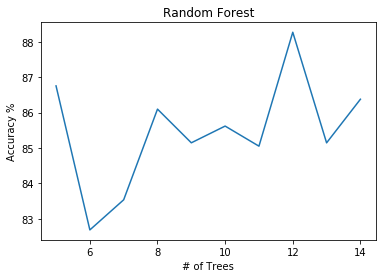

In [2]:
from random import seed
from random import randrange
from csv import reader
import sklearn
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from pandas import ExcelFile
from pandas import ExcelWriter
from sklearn.preprocessing import OneHotEncoder 

df = pd.read_excel('Disposition Data.xlsx', sheet_name='Sheet1')
#reading data from dataset into pandas dataframe
B = df.select_dtypes(exclude=[object])
A = df.select_dtypes(include=[object])
#selecting only object data types 
A.head(3)
A.shape
from sklearn import preprocessing
A.columns
#preprocessing object data with sklearn label encoder
le = preprocessing.LabelEncoder()
X_2 = A.apply(le.fit_transform)
X_2.head()

#combining newly labeled object data with old data
C = pd.concat([B,X_2],axis=1)
C = C.fillna(0)

#splitting dataset into features and labels
y = C["IA"]
x = C.drop('IA', axis=1)

#trying PCA on features
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(x)

# x = principalComponents

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#Number of trees to use for random forest, number of cross validation folds, and % train/test split data were all tested using the random forest classifier
#as it displayed the highest accuracy of any other algorithm
Number_of_trees=[]
def trees (p):
    for i in range(10):
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.4)
        #splitting data into training set and test set
        from sklearn.ensemble import RandomForestClassifier
        rfc = RandomForestClassifier(n_jobs=-1, n_estimators=p)
        #fitting data to sklearn random forest classifier
        rfc.fit(X_train, y_train)
        print ("Accuracy for Random Forest:",rfc.score(X_test, y_test))
        #getting accuracy for random forest

        from sklearn.model_selection import cross_val_score
        scores = cross_val_score(rfc, X_test, y_test, cv=5)
        #cross validating accuracy scores
        import statistics
        print(statistics.mean(scores))
        Number_of_trees.append(statistics.mean(scores)*100)
        p+=1
        #increasing number of trees ever loop
trees(5)
import matplotlib.pyplot as plt
x = [i for i in range(5,15)]
y= Number_of_trees

plt.plot(x,y)
plt.title (r"Random Forest")
plt.xlabel(r"# of Trees")
plt.ylabel(r"Accuracy %")

2112/2112 [==============================] - 0s 17us/step

acc: 38.59%
2112/2112 [==============================] - 0s 18us/step

acc: 39.35%
2112/2112 [==============================] - 0s 18us/step

acc: 38.97%
2112/2112 [==============================] - 0s 19us/step

acc: 39.06%
2112/2112 [==============================] - 0s 23us/step

acc: 38.16%
2112/2112 [==============================] - 0s 20us/step

acc: 39.39%
2112/2112 [==============================] - 0s 23us/step

acc: 38.73%
2112/2112 [==============================] - 0s 20us/step

acc: 37.69%
2112/2112 [==============================] - 0s 21us/step

acc: 37.93%
2112/2112 [==============================] - 0s 19us/step

acc: 37.74%


Text(0, 0.5, 'Accuracy %')

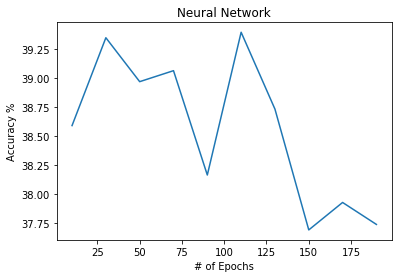

In [26]:
from random import seed
from random import randrange
from csv import reader
import sklearn
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from pandas import ExcelFile
from pandas import ExcelWriter
from sklearn.preprocessing import OneHotEncoder 
import keras
from keras.models import Sequential
from keras.layers import Dense

df = pd.read_excel('Disposition Data.xlsx', sheet_name='Sheet1')
#reading data from dataset into pandas dataframe
B = df.select_dtypes(exclude=[object])
A = df.select_dtypes(include=[object])
#selecting only object data types 
A.head(3)
A.shape
from sklearn import preprocessing
A.columns
le = preprocessing.LabelEncoder()
#preprocessing object data with sklearn label encoder
X_2 = A.apply(le.fit_transform)
X_2.head()
#combining newly labeled object data with old data
C = pd.concat([B,X_2],axis=1)
C = C.fillna(0)
#splitting dataset into features and labels
y = C["IA"]
x = C.drop('IA', axis=1)
#applying PCA to features PCA seemed to have little impact on results
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2)
# principalComponents = pca.fit_transform(x)

# x = principalComponents


#looping through neural network to see if different number of epochs would effect accuracy
Number_of_Epochs=[]
q_value=[]
def epochs (q):
     for i in range(10):
        from sklearn.model_selection import train_test_split
        from sklearn.metrics import accuracy_score
        #splitting data into training set and test set
        X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
        model = Sequential()
        #using model from keras to build neural network
        model.add(Dense(10, input_dim=8, activation='relu'))
        #starting first layer with 8 input dimensions and creating 10 neurons from them using relu activation
        model.add(Dense(150, activation='relu'))
        #adding 2nd layer with 150 neurons as well with relu activation. 
        model.add(Dense(100, activation='relu'))
        #adding 3rd layer with 100 neurons as well with relu activation. 
        model.add(Dense(75, activation='sigmoid'))
        #adding 4th layer with 75 neurons as well with sigmoid activation.
        model.add(Dense(1, activation='relu'))
        #final output layer which returns our one output desired
        from keras import optimizers
        sgd = optimizers.SGD(lr=0.01)
        #defining learning rate for optimizer
        model.compile(loss='mean_absolute_percentage_error', optimizer='sgd', metrics=['accuracy'])
        #compiling model defined above. I tried many differnt loss functions and optimization algorithms but these seemed to work the best by far


        history = model.fit(X_train, y_train, validation_split=0.33, epochs=10, batch_size=5, verbose =0)
        #Fitting the model to a training set and test set, saving 33% of the data to test on. 
        #Setting the Epochs to 100 because after 100 there seems to be little increase in accuracy
        #Verbose was changed for clarity of display, I used verbose 1 when actually changing parameters
        scores = model.evaluate(X_train, y_train)
        predictions = model.predict(X_train)
        print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        from sklearn.metrics import confusion_matrix
        #cm = confusion_matrix(y_test, y_pred)  
        #Evaulating model's performance
        Number_of_Epochs.append(scores[1]*100)
        q_value.append(q)
        q+=20
        

epochs(10)
import matplotlib.pyplot as plt
x = q_value
y= Number_of_Epochs
#plotting number of epochs vs accuracy
plt.plot(x,y)
plt.title (r"Neural Network")
plt.xlabel(r"# of Epochs")
plt.ylabel(r"Accuracy %")
#attempted to create confusion matrix with results to see if there were any imbalances, however, results were not as clear as desired      
#total = sum(sum(cm))
#acc = (cm[0, 0] + cm[1, 1]) / total
#sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
#specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
 
# show the confusion matrix, accuracy, sensitivity, and specificity
#print(cm)
#print("acc: {:.4f}".format(acc))
#print("sensitivity: {:.4f}".format(sensitivity))
#print("specificity: {:.4f}".format(specificity))


#PARAMETER TUNING:
#tried adding more layers but after 5 layers seemed to have little impact in accuracies
#changing number of nuerons at each layer also seemed to have minimal impact
#tried different activation functions, however, relu seemed to work best in most layers
#learning rate had little impact on performance
#epochs had little impact on perfornace
#some loss functions functions were much stronger than others, "mean_absolute_percentage_error" performed best from testing
#optimizer functions had little impact on performance